In [10]:
%pip install pandas numpy networkx matplotlib scikit-learn seaborn nltk --quiet

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
import random
import json

In [2]:
df_posts = pd.read_csv("../../../data/post_data.csv")
df_replies = pd.read_csv("../../../data/replies_data.csv")
follower = "../../../data/output.json"
with open(follower, "r", encoding="utf-8") as file:
    dati = json.load(file)

In [3]:
missing_columns_in_posts = [col for col in df_replies.columns if col not in df_posts.columns]

for col in missing_columns_in_posts:
    df_posts[col] = np.nan

df_combined = pd.concat([df_posts, df_replies], ignore_index=True)
df_combined.columns = [col.lower().replace(" ", "_") for col in df_combined.columns]
df_combined.drop(columns=["parent_post_id","direct_reply_count"	,"repost_count","following","followed_by","can_reply","reply_control","reshare_count","is_verified"],axis=1,inplace=True)
df_combined.head()

,post_id,user_id,thread_type,username,profile_picture_url,text_post,like_count,quote_count,caption_text
0,3481594135434044840,62926993725,thread,simolude_ai,https://scontent-fco2-1.cdninstagram.com/v/t51...,Aston Martin for you.\r\n\r\nFor more pics ple...,7,0.0,Aston Martin for you.\r\n\r\nFor more pics ple...
1,3482097309088055950,38077850387,thread,vita.consacrata,https://scontent-fco2-1.cdninstagram.com/v/t51...,#genere #intelligenzaartificiale,0,0.0,#genere #intelligenzaartificiale
2,3481793127636829981,1501070805,thread,robymagno65,https://scontent-fco2-1.cdninstagram.com/v/t51...,#intelligenzaartificiale #foto #ottobre #fotog...,2,0.0,#intelligenzaartificiale #foto #ottobre #fotog...
3,3438852681247108598,65532133383,thread,news.scienze,https://scontent-fco2-1.cdninstagram.com/v/t51...,La conoscenza della macchina intesa come Intel...,3,0.0,La conoscenza della macchina intesa come Intel...
4,3446085903746401933,24736383042,thread,rakesh_yadav_200k,https://scontent-fco2-1.cdninstagram.com/v/t51...,#IntelligenzaArtificiale,21,0.0,#IntelligenzaArtificiale


In [4]:
df_combined.shape

(23052, 9)

In [5]:
df = df_combined.drop_duplicates()
# 2. Riempimento dei NaN nelle colonne di conteggio con 0 (queste colonne sono quantitative)
df['like_count'] = df['like_count'].fillna(0)
df['quote_count'] = df['quote_count'].fillna(0)

# 3. Conversione dei tipi di dati
# Assicuriamoci che i conteggi siano di tipo intero
count_columns = ['like_count', 'quote_count']

for col in count_columns:
    df[col] = df[col].astype(int)

In [23]:
G = nx.DiGraph()
for user_id, user_data in dati.items():
    user_info = df.loc[df['user_id'] == int(user_id)].to_dict(orient='records')
    if not G.has_node(int(user_id)):
        G.add_node(int(user_id), info=user_info)

    followers = user_data.get("followers", [])
    for follower in followers:
        follower_username = int(follower["user_id"])

        follower_info = df.loc[df['user_id'] == follower_username].to_dict(orient='records')

        if not G.has_node(follower_username):
           G.add_node(follower_username, info=follower_info)

        G.add_edge(follower_username, int(user_id))





G_info = {
    'numero_nodi': G.number_of_nodes(),
    'numero_archi': G.number_of_edges(),
    'esempio_nodi': list(G.nodes(data=True))[:5],  # Prime 5 nodi con attributi
    'esempio_archi': list(G.edges(data=True))[:5]  # Prime 5 archi con attributi
}

G_info


{'numero_nodi': 10822,
 'numero_archi': 10713,
 'esempio_nodi': [(62926993725,
   {'info': [{'post_id': 3481594135434044840,
      'user_id': 62926993725,
      'thread_type': 'thread',
      'username': 'simolude_ai',
      'profile_picture_url': 'https://scontent-fco2-1.cdninstagram.com/v/t51.2885-19/459032079_1450255862352365_3270406893771965895_n.jpg?stp=dst-jpg_s150x150&_nc_ht=scontent-fco2-1.cdninstagram.com&_nc_cat=105&_nc_ohc=s-ew1TENjzQQ7kNvgHPIBiH&_nc_gid=57f2378e344348039cdf965dba35abb5&edm=APs17CUBAAAA&ccb=7-5&oh=00_AYCmx6E8PHp6Ba2EOJ6_JnrThgiQqYLmzAFD_zz0pisOzA&oe=67194644&_nc_sid=10d13b',
      'text_post': 'Aston Martin for you.\r\n\r\nFor more pics please follow ',
      'like_count': 7,
      'quote_count': 0.0,
      'caption_text': 'Aston Martin for you.\r\n\r\nFor more pics please follow @simolude_ai\r\n#render #design #intelligenzaartificiale #aiart  #aiphotography  #aicar  #aiartwork  #aiartcommunity  #ai  #aicars  #aiartist  #aicommunity #carspotted\r\n#automotiv

In [12]:
!set LOKY_MAX_CPU_COUNT=16

In [15]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Scarica risorse di NLTK
nltk.download('vader_lexicon')

# 1. Preprocessing dei dati
df = df_combined.copy()

# Pulizia dei testi
df['clean_text'] = df['text_post'].fillna('').str.lower()

# Analisi del sentiment
sia = SentimentIntensityAnalyzer()

# Calcola il punteggio di sentiment per ogni post
df['sentiment'] = df['clean_text'].apply(lambda x: sia.polarity_scores(x)['compound'])

display(df)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\pasqu\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,post_id,user_id,thread_type,username,profile_picture_url,text_post,like_count,quote_count,caption_text,clean_text,sentiment
0,3481594135434044840,62926993725,thread,simolude_ai,https://scontent-fco2-1.cdninstagram.com/v/t51...,Aston Martin for you.\r\n\r\nFor more pics ple...,7,0.0,Aston Martin for you.\r\n\r\nFor more pics ple...,aston martin for you.\r\n\r\nfor more pics ple...,0.3774
1,3482097309088055950,38077850387,thread,vita.consacrata,https://scontent-fco2-1.cdninstagram.com/v/t51...,#genere #intelligenzaartificiale,0,0.0,#genere #intelligenzaartificiale,#genere #intelligenzaartificiale,0.0000
2,3481793127636829981,1501070805,thread,robymagno65,https://scontent-fco2-1.cdninstagram.com/v/t51...,#intelligenzaartificiale #foto #ottobre #fotog...,2,0.0,#intelligenzaartificiale #foto #ottobre #fotog...,#intelligenzaartificiale #foto #ottobre #fotog...,0.0000
3,3438852681247108598,65532133383,thread,news.scienze,https://scontent-fco2-1.cdninstagram.com/v/t51...,La conoscenza della macchina intesa come Intel...,3,0.0,La conoscenza della macchina intesa come Intel...,la conoscenza della macchina intesa come intel...,0.8720
4,3446085903746401933,24736383042,thread,rakesh_yadav_200k,https://scontent-fco2-1.cdninstagram.com/v/t51...,#IntelligenzaArtificiale,21,0.0,#IntelligenzaArtificiale,#intelligenzaartificiale,0.0000
...,...,...,...,...,...,...,...,...,...,...,...
23047,3485858740701613872,59015056688,reply,ameenu.est,https://scontent-fco2-1.cdninstagram.com/v/t51...,Always towards the perfections 🔥🥰🌷😘🤗😘🤗😘🤗😘🤗,0,0.0,Always towards the perfections 🔥🥰🌷😘🤗😘🤗😘🤗😘🤗,always towards the perfections 🔥🥰🌷😘🤗😘🤗😘🤗😘🤗,0.5423
23048,3483873961170436078,67166030959,reply,m.viishal,https://scontent-fco2-1.cdninstagram.com/v/t51...,"Day 4 of using #Threads, \r\nDay of 4 of 15 da...",5,0.0,"Day 4 of using #Threads, \r\nDay of 4 of 15 da...","day 4 of using #threads, \r\nday of 4 of 15 da...",0.0000
23049,3485293422550663152,2234991764,reply,winbuzzer,https://scontent-fco2-1.cdninstagram.com/v/t51...,ICYMI: Anthropic has revealed a new feature in...,1,0.0,ICYMI: Anthropic has revealed a new feature in...,icymi: anthropic has revealed a new feature in...,0.3612
23050,3483066692346191865,68855917549,reply,aispeeds,https://scontent-fco2-1.cdninstagram.com/v/t51...,If any one want this type of ai editing messa...,0,0.0,If any one want this type of ai editing messa...,if any one want this type of ai editing messa...,0.0772


In [17]:
# 2. Preparazione dei dati per il clustering
# Trasforma i testi in rappresentazioni vettoriali TF-IDF
vectorizer = TfidfVectorizer(max_features=500)  # Numero massimo di caratteristiche da considerare
X_tfidf = vectorizer.fit_transform(df['clean_text'])

# Clustering con K-means
n_clusters = 5  # Numero di cluster scelto arbitrariamente
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(X_tfidf)

display(df)

,post_id,user_id,thread_type,username,profile_picture_url,text_post,like_count,quote_count,caption_text,clean_text,sentiment,cluster
0,3481594135434044840,62926993725,thread,simolude_ai,https://scontent-fco2-1.cdninstagram.com/v/t51...,Aston Martin for you.\r\n\r\nFor more pics ple...,7,0.0,Aston Martin for you.\r\n\r\nFor more pics ple...,aston martin for you.\r\n\r\nfor more pics ple...,0.3774,4
1,3482097309088055950,38077850387,thread,vita.consacrata,https://scontent-fco2-1.cdninstagram.com/v/t51...,#genere #intelligenzaartificiale,0,0.0,#genere #intelligenzaartificiale,#genere #intelligenzaartificiale,0.0000,0
2,3481793127636829981,1501070805,thread,robymagno65,https://scontent-fco2-1.cdninstagram.com/v/t51...,#intelligenzaartificiale #foto #ottobre #fotog...,2,0.0,#intelligenzaartificiale #foto #ottobre #fotog...,#intelligenzaartificiale #foto #ottobre #fotog...,0.0000,0
3,3438852681247108598,65532133383,thread,news.scienze,https://scontent-fco2-1.cdninstagram.com/v/t51...,La conoscenza della macchina intesa come Intel...,3,0.0,La conoscenza della macchina intesa come Intel...,la conoscenza della macchina intesa come intel...,0.8720,0
4,3446085903746401933,24736383042,thread,rakesh_yadav_200k,https://scontent-fco2-1.cdninstagram.com/v/t51...,#IntelligenzaArtificiale,21,0.0,#IntelligenzaArtificiale,#intelligenzaartificiale,0.0000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
23047,3485858740701613872,59015056688,reply,ameenu.est,https://scontent-fco2-1.cdninstagram.com/v/t51...,Always towards the perfections 🔥🥰🌷😘🤗😘🤗😘🤗😘🤗,0,0.0,Always towards the perfections 🔥🥰🌷😘🤗😘🤗😘🤗😘🤗,always towards the perfections 🔥🥰🌷😘🤗😘🤗😘🤗😘🤗,0.5423,1
23048,3483873961170436078,67166030959,reply,m.viishal,https://scontent-fco2-1.cdninstagram.com/v/t51...,"Day 4 of using #Threads, \r\nDay of 4 of 15 da...",5,0.0,"Day 4 of using #Threads, \r\nDay of 4 of 15 da...","day 4 of using #threads, \r\nday of 4 of 15 da...",0.0000,0
23049,3485293422550663152,2234991764,reply,winbuzzer,https://scontent-fco2-1.cdninstagram.com/v/t51...,ICYMI: Anthropic has revealed a new feature in...,1,0.0,ICYMI: Anthropic has revealed a new feature in...,icymi: anthropic has revealed a new feature in...,0.3612,1
23050,3483066692346191865,68855917549,reply,aispeeds,https://scontent-fco2-1.cdninstagram.com/v/t51...,If any one want this type of ai editing messa...,0,0.0,If any one want this type of ai editing messa...,if any one want this type of ai editing messa...,0.0772,0


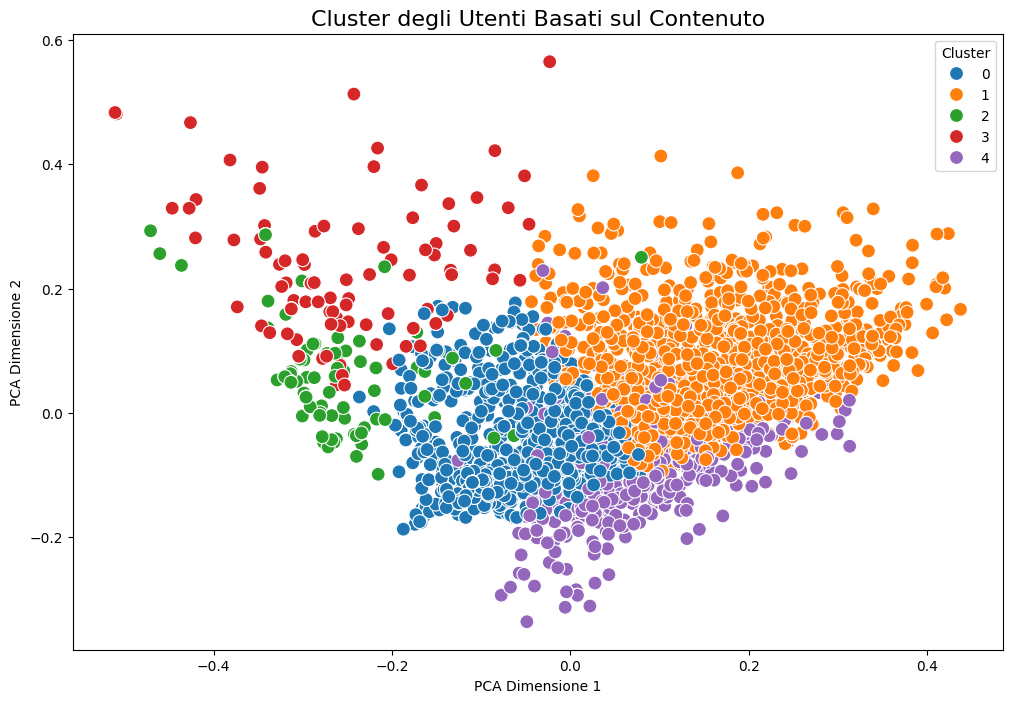

In [19]:


# 3. Visualizzazione della polarizzazione
# Riduzione della dimensionalità con PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray())

# Aggiungi le coordinate PCA al dataframe
df['pca1'] = X_pca[:, 0]
df['pca2'] = X_pca[:, 1]

# Visualizza i cluster
plt.figure(figsize=(12, 8))
sns.scatterplot(x='pca1', y='pca2', hue='cluster', data=df, palette='tab10', s=100)
plt.title('Cluster degli Utenti Basati sul Contenuto', fontsize=16)
plt.xlabel('PCA Dimensione 1')
plt.ylabel('PCA Dimensione 2')
plt.legend(title='Cluster')
plt.show()

In [22]:
print("Numero di nodi nel grafo:", len(G.nodes))
print("Numero di utenti nel dataset:", len(df['user_id'].unique()))


Numero di nodi nel grafo: 10822
Numero di utenti nel dataset: 2898


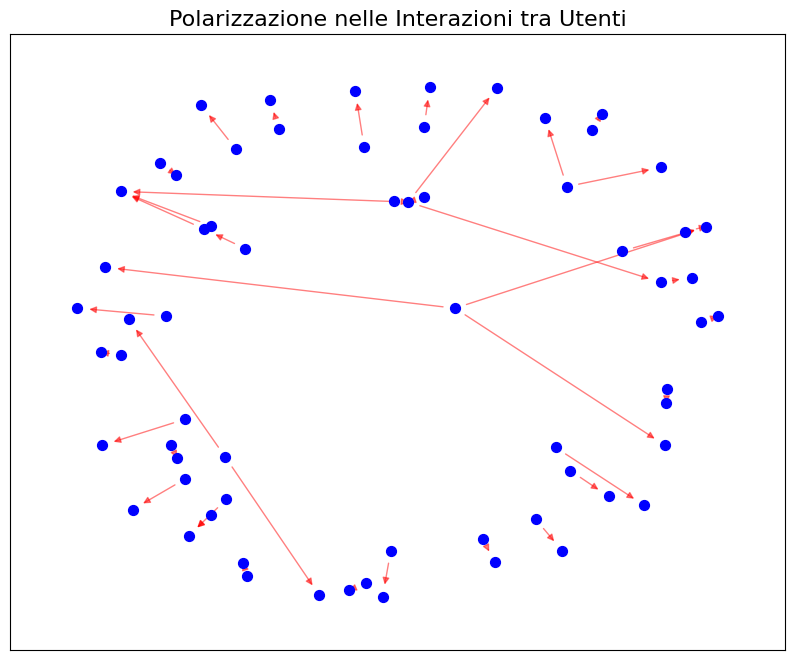

In [24]:
# 4. Analisi della rete sociale
# Crea una lista degli utenti per cluster
cluster_users = {i: df[df['cluster'] == i]['user_id'].tolist() for i in range(n_clusters)}

polarized_edges = []
for cluster, users in cluster_users.items():
    for user in users:
        if user not in G:
            continue  # Salta il nodo mancante
        for neighbor in G.successors(user):  # Connessioni uscenti
            if neighbor not in users:  # Polarizzazione: connessioni inter-cluster
                polarized_edges.append((user, neighbor))

# Visualizza la rete polarizzata
polarized_graph = nx.DiGraph()
polarized_graph.add_edges_from(polarized_edges)

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(polarized_graph, seed=42)
nx.draw_networkx_nodes(polarized_graph, pos, node_size=50, node_color='blue')
nx.draw_networkx_edges(polarized_graph, pos, edge_color='red', alpha=0.5)
plt.title('Polarizzazione nelle Interazioni tra Utenti', fontsize=16)
plt.show()
